# Imports

In [1]:
from PIL import Image
import requests
import os
import numpy as np
import torch

from transformers import (
    CLIPProcessor,
    CLIPModel,
    AlignProcessor,
    AlignModel,
    AutoTokenizer                      
)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier

2023-11-18 15:48:58.119041: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-18 15:48:58.736529: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = "cuda:0"

-----------

# Tarefa 1: Classificador zero-shot utilizando o prompt da categoria.

## Leitura das imagens

In [3]:
def read_images(path):
    images = []
    labels = []
    categories = os.listdir(path)

    # Ler as imagens da pasta test
    for root, dirs, files in os.walk(path):
        for file in files:
            full_path = os.path.join(root, file)
            
            image = Image.open(full_path).convert("RGB")
            images.append(image)
            labels.append(categories.index(root.split('/')[-1]))
            
    return images, labels, categories


In [4]:
images_test, labels_test, categories_test = read_images('./original/test/')

In [5]:
len(images_test)

5286

## Define os modelos e o prompt

In [6]:
prompt = "This is a photo of a {}."

texts = [prompt.format(category) for category in categories_test]

model_clip_name = "openai/clip-vit-base-patch32"
model_align_name = "kakaobrain/align-base"

model_clip = CLIPModel.from_pretrained(model_clip_name)
processor_clip = CLIPProcessor.from_pretrained(model_clip_name)

model_align = AlignModel.from_pretrained(model_align_name)
processor_align = AlignProcessor.from_pretrained(model_align_name)

In [7]:
model_clip = model_clip.to(device)
model_align = model_align.to(device)

In [8]:
texts

['This is a photo of a ship.',
 'This is a photo of a dog.',
 'This is a photo of a bird.',
 'This is a photo of a truck.',
 'This is a photo of a car.',
 'This is a photo of a plane.',
 'This is a photo of a cat.',
 'This is a photo of a equine.',
 'This is a photo of a frog.',
 'This is a photo of a deer.']

## Função de Inferência

In [17]:
def inferance(image, texts, model, processor): 
    inputs = processor(text=texts, images=image, return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    return probs

## Realiza predição por batch

In [12]:
def predict_batch(images, batch_size, texts, model, processor):
    with torch.no_grad():
        preds = []
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size]
            preds += inferance(batch, texts, model, processor).argmax(dim=1).tolist()
            
    return preds

### CLIP

In [13]:
preds_clip = predict_batch(images_test, 32, texts, model_clip, processor_clip)

### Align

In [18]:
preds_align = predict_batch(images_test, 32, texts, model_align, processor_align)

## Avaliação

## Métricas

Como estamos solucionando uma tarefa de classificação multi-classe será utilizado métricas típicas da literatura para avaliar a performance do modelo na configuração zero-shot

### Acurácia, Precisão e Recall

#### CLIP

In [19]:
print(classification_report(labels_test, preds_clip, target_names=categories_test))

              precision    recall  f1-score   support

        ship       0.99      1.00      1.00       532
         dog       0.98      0.98      0.98       531
        bird       0.99      1.00      0.99       533
       truck       0.96      0.99      0.97       502
         car       0.99      0.96      0.97       534
       plane       1.00      0.99      1.00       529
         cat       0.99      0.98      0.98       532
      equine       0.96      0.96      0.96       533
        frog       1.00      0.99      1.00       530
        deer       0.97      0.96      0.96       530

    accuracy                           0.98      5286
   macro avg       0.98      0.98      0.98      5286
weighted avg       0.98      0.98      0.98      5286



#### ALIGN

In [20]:
print(classification_report(labels_test, preds_align, target_names=categories_test))

              precision    recall  f1-score   support

        ship       1.00      0.98      0.99       532
         dog       1.00      0.99      0.99       531
        bird       1.00      1.00      1.00       533
       truck       0.98      0.99      0.98       502
         car       0.95      1.00      0.97       534
       plane       1.00      0.99      0.99       529
         cat       0.98      1.00      0.99       532
      equine       0.97      0.93      0.95       533
        frog       1.00      0.99      1.00       530
        deer       0.98      0.98      0.98       530

    accuracy                           0.98      5286
   macro avg       0.98      0.98      0.98      5286
weighted avg       0.98      0.98      0.98      5286



Analisando os resultados, percebe-se que ambos os modelos obtiveram uma performance extramemente boa no conjunto de teste na configuração zero-shot, ambos obtendo uma acurácia de 98% e resultados extramemente altos para precisão, recall e f1 score para cada das categorias

### Confusion Matrix

#### CLIP

<Axes: >

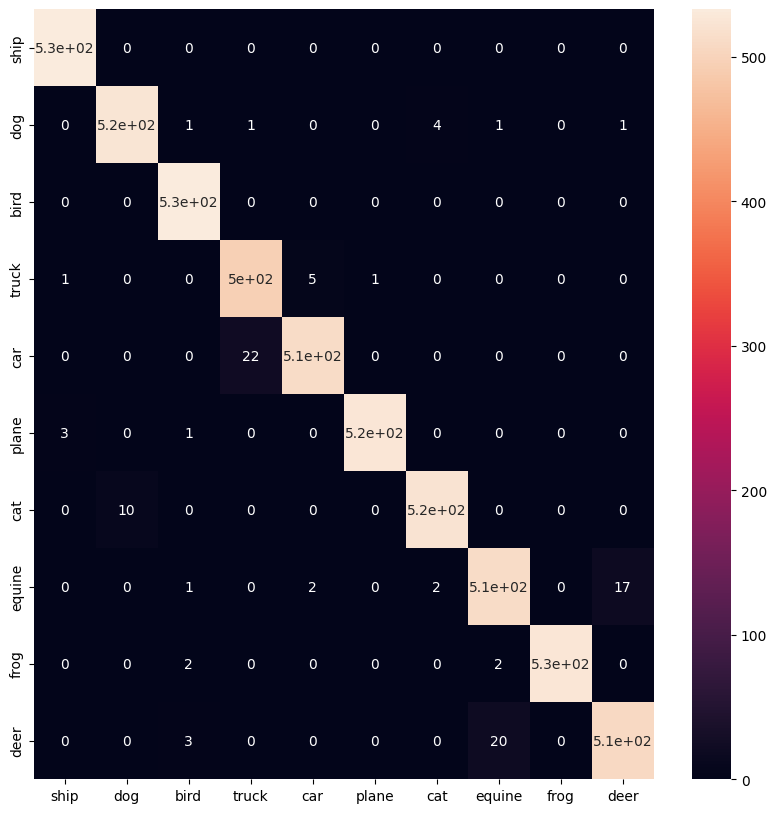

In [21]:
cm = confusion_matrix(labels_test, preds_clip)

_, ax = plt.subplots(figsize=(10, 10)) 
sns.heatmap(cm, annot=True, xticklabels=categories_test, yticklabels=categories_test, ax=ax)

#### ALIGN

<Axes: >

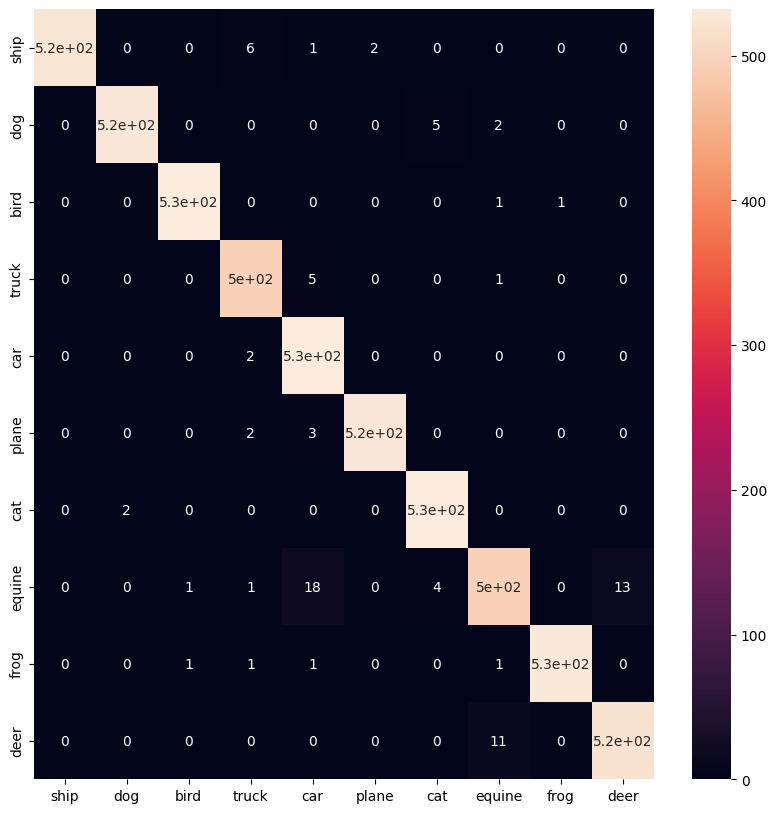

In [22]:
cm = confusion_matrix(labels_test, preds_align)

_, ax = plt.subplots(figsize=(10, 10)) 
sns.heatmap(cm, annot=True, xticklabels=categories_test, yticklabels=categories_test, ax=ax)

A matriz de confusão apresenta, visualmente, o resultado visto com as métricas anteriomente, com uma acurácia muito alta representada pela diagional principal muito preenchida e concentrada.

# Tarefa 2: Classificador utilizando o KNN e os embeddings das imagens

## Ler imagens de Treino

In [9]:
train_image, train_label, train_categories = read_images('./original/train/')

In [10]:
len(train_image)

21098

## Extrai os embeddings das imagens

In [11]:
def extract_image_features(images, processor, model):
    with torch.no_grad():
        inputs = processor(images=images, return_tensors="pt").to(device)
        outputs = model.get_image_features(**inputs)
        embeddings = outputs.detach().cpu().numpy()
    return embeddings

def extract_image_features_batch(images, batch_size, processor, model):
    embeddings = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        embeddings.append(extract_image_features(batch, processor, model))
    return np.concatenate(embeddings)

### CLIP

In [12]:
embeddings_clip = extract_image_features_batch(train_image, 32, processor_clip, model_clip)

In [14]:
embeddings_clip.shape

(21098, 512)

### ALIGN

In [13]:
embeddings_align = extract_image_features_batch(train_image, 32, processor_align, model_align)

In [15]:
embeddings_align.shape

(21098, 640)

## Define os modelos KNN

In [16]:
knn_5_clip = KNeighborsClassifier(n_neighbors=5)
knn_7_clip = KNeighborsClassifier(n_neighbors=7)
knn_13_clip = KNeighborsClassifier(n_neighbors=13)

knn_5_align = KNeighborsClassifier(n_neighbors=5)
knn_7_align = KNeighborsClassifier(n_neighbors=7)
knn_13_align = KNeighborsClassifier(n_neighbors=13)

## Fit nos KNN

In [17]:
knn_5_clip.fit(embeddings_clip, train_label)
knn_7_clip.fit(embeddings_clip, train_label)
knn_13_clip.fit(embeddings_clip, train_label)

knn_5_align.fit(embeddings_align, train_label)
knn_7_align.fit(embeddings_align, train_label)
knn_13_align.fit(embeddings_align, train_label)

KNeighborsClassifier(n_neighbors=13)

## Avaliação Base de Teste

### Embeddings das imagens de teste

In [18]:
embeddings_test_clip = extract_image_features_batch(images_test, 32, processor_clip, model_clip)

In [19]:
embeddings_test_align = extract_image_features_batch(images_test, 32, processor_align, model_align)

### Predições

In [21]:
pred_knn_5_clip =  knn_5_clip.predict(embeddings_test_clip)
pred_knn_7_clip =  knn_7_clip.predict(embeddings_test_clip)
pred_knn_13_clip = knn_13_clip.predict(embeddings_test_clip)

pred_knn_5_align = knn_5_align.predict(embeddings_test_align)
pred_knn_7_align = knn_7_align.predict(embeddings_test_align)
pred_knn_13_align = knn_13_align.predict(embeddings_test_align)

### Calcula Métricas

#### Acurácia, Precisão e Recall

##### CLIP #####

In [22]:
print(classification_report(labels_test, pred_knn_5_clip, target_names=categories_test))
print('-'*100)
print(classification_report(labels_test, pred_knn_7_clip, target_names=categories_test))
print('-'*100)
print(classification_report(labels_test, pred_knn_13_clip, target_names=categories_test))
print('-'*100)

              precision    recall  f1-score   support

        ship       0.99      1.00      1.00       532
         dog       1.00      0.99      1.00       531
        bird       0.99      1.00      1.00       533
       truck       0.99      0.98      0.98       502
         car       0.99      0.99      0.99       534
       plane       0.99      0.99      0.99       529
         cat       0.99      0.99      0.99       532
      equine       0.98      0.99      0.99       533
        frog       1.00      1.00      1.00       530
        deer       0.98      0.98      0.98       530

    accuracy                           0.99      5286
   macro avg       0.99      0.99      0.99      5286
weighted avg       0.99      0.99      0.99      5286

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

        ship       0.99      1.00      1.00       532
         dog       1.00      0.

#### ALIGN

In [23]:
print(classification_report(labels_test, pred_knn_5_align, target_names=categories_test))
print('-'*100)
print(classification_report(labels_test, pred_knn_7_align, target_names=categories_test))
print('-'*100)
print(classification_report(labels_test, pred_knn_13_align, target_names=categories_test))
print('-'*100)

              precision    recall  f1-score   support

        ship       1.00      1.00      1.00       532
         dog       1.00      0.99      0.99       531
        bird       1.00      1.00      1.00       533
       truck       0.99      0.99      0.99       502
         car       0.99      0.99      0.99       534
       plane       1.00      1.00      1.00       529
         cat       0.99      0.99      0.99       532
      equine       0.99      0.99      0.99       533
        frog       1.00      1.00      1.00       530
        deer       0.99      0.99      0.99       530

    accuracy                           0.99      5286
   macro avg       0.99      0.99      0.99      5286
weighted avg       0.99      0.99      0.99      5286

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

        ship       1.00      1.00      1.00       532
         dog       1.00      0.

Analisando os resultados, percebe-se uma performance extramemente boa no conjunto de teste, com uma acurácia de 99% para ambos os modelos e escolhas do número de vizinhos considerados (5, 7 e 13).m

### Confusion Matrix

#### CLIP 

<Axes: >

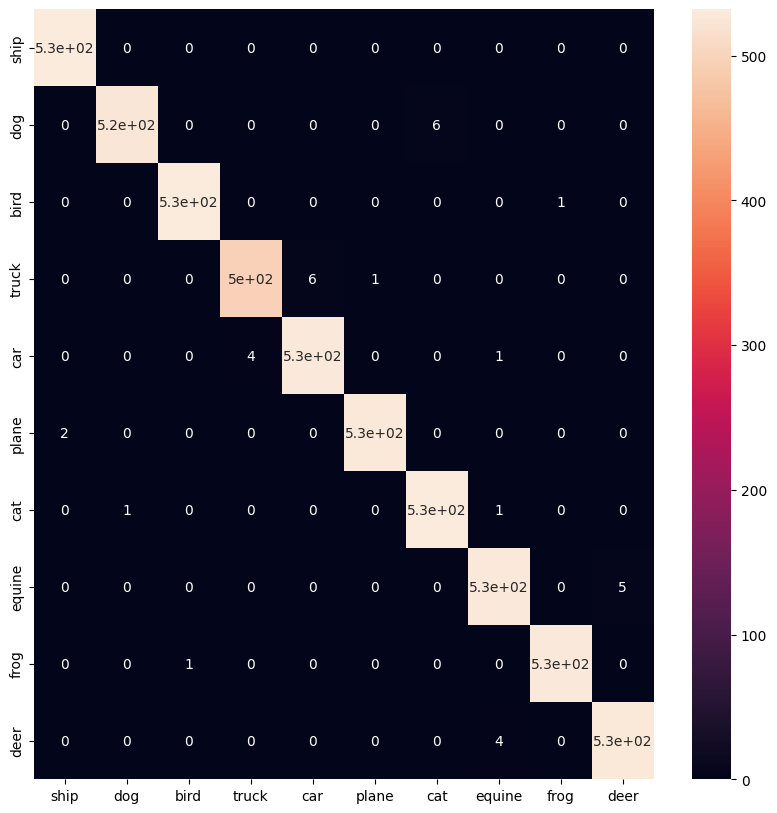

In [25]:
cm = confusion_matrix(labels_test, pred_knn_13_align)

_, ax = plt.subplots(figsize=(10, 10)) 
sns.heatmap(cm, annot=True, xticklabels=categories_test, yticklabels=categories_test, ax=ax)

#### ALIGN

<Axes: >

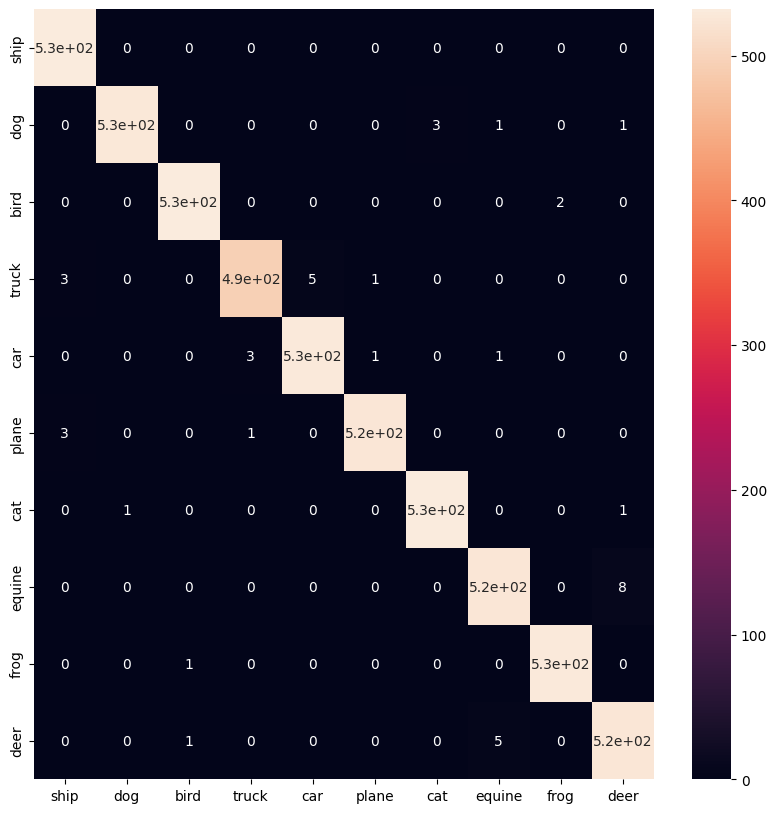

In [26]:
cm = confusion_matrix(labels_test, pred_knn_13_clip)

_, ax = plt.subplots(figsize=(10, 10)) 
sns.heatmap(cm, annot=True, xticklabels=categories_test, yticklabels=categories_test, ax=ax)

# Atividade 3: Comparar e discutir os resultados obtidos com o modelo CLIP e o ALIGN 

Os resultados obtidos com o CLIP e ALIGN nas duas atividades anteriores, uma na configuração Zero-shot e na outra utilizando o KNN com os embeddings dos modelos resultaram em resultados extremamentes satisfatórios.<br><br>
**Atividade 1**<br>
Na primeira atividade ambos os modelos obtiveram 98% de acurácia no conjunto de teste do dataset e resultados extramemente satisfatórios nas métricas para cada categoria como Precision, Recall e F1-score, com médias muito próximas de 100%.

**Atividade 2**<br>
Com a abordagem da atividade 2, na qual foi aplicado o KNN com K igual a 5, 7 e 13, foi possível melhorar ainda mais a performance do modelo, para as 3 escolhas de K ambos os modelos conseguiram uma acurácia de 99% no conjunto de teste do modelo.

Foi plotado matriz de confusão para o modelo KNN com K igual a 13 para essa segunda abordagem, nela foi possível visualizar a performance e comparar com a da primeira abordagem. Foi possível identificar que o novo resultado diminuiu a quantidade de elementos fora da diagional principal da matriz, ou seja, reduziu erros.

Para o caso do CLIP, o resultado da atividade 1 teve 22 casos errados onde um caminhão foi predito como carro e 10 onde um cachorro foi predito como um gato, já na abordagem com KNN esse número se reduziu para 3 e 1, respectivamentes.

E Para o caso do ALIGN, o resultado da atividade 1 teve 18 casos errados onde um carro foi predito como um equino e 11 onde um equino foi predito como um veado, já na abordagem da segunda atividade esse número se reduziu para 0 e 5, respectivamentes.